# GMM Classification Experiments 


We experiment with 2D logistic models.

In [1]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from copy import deepcopy
import matplotlib.pyplot as plt
from layered_unlearning.utils import set_seed
from layered_unlearning.gmm_classification import (
    Gaussian,
    GaussianMixture,
    LogisticModel,
    Uniform,
    train,
    evaluate,
    construct_dataset,
)
import seaborn as sns
from pathlib import Path
from typing import Dict, List
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np
from matplotlib.patches import Patch

seed = set_seed(0)

## Hyperparameters
Default hyperparameters for our experiments. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 3
lr = 1e-2
batch_size = 32
n_classes = 2
n_samples = 5000
dim = 2
weight_decay = 0.0
weight_delta_penalty = 0.0

rbf = True
rbf_sigma = 8
rbf_width = 60
rbf_num = 12
degree = 0

eps = 1e-8
n_layers = 0
batch_norm = True
hidden_dim = 128

loss_type = "cross_entropy"

cov_scale = 4
cov_perturb = 0.1
mu_width = 50
uniform_half_width = 60
n_classes = 10
clustering = "random"  # random, k-means, adversarial


def mu_gen():
    return torch.rand((dim,)) * 2 * mu_width - mu_width


def cov_gen():
    base = torch.eye(dim) * cov_scale
    U = torch.randn((dim, dim))
    perturb = U.T @ U * cov_perturb
    return base + perturb


def get_gaussian_mixture(
    n_classes: int,
    mu_list: List[torch.Tensor] = None,
    cov_list: List[torch.Tensor] = None,
) -> GaussianMixture:
    classes = []
    for i in range(n_classes):
        classes.append(
            Gaussian(
                mu=mu_gen() if mu_list is None else mu_list[i],
                cov=cov_gen() if cov_list is None else cov_list[i],
            )
        )

    mixture = GaussianMixture(
        classes=classes,
        weights=torch.ones(n_classes) / n_classes,
    )
    return mixture


def get_even_clusters(X: np.ndarray, cluster_size: int):
    n_clusters = int(np.ceil(len(X) / cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = (
        centers.reshape(-1, 1, X.shape[-1])
        .repeat(cluster_size, 1)
        .reshape(-1, X.shape[-1])
    )
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1] // cluster_size
    return clusters


def get_mixture(mus: List, covs: List, weights: List = None):
    n = len(mus)
    if weights is None:
        weights = [1 / n] * n
    return GaussianMixture(
        classes=[
            Gaussian(mu=torch.tensor(mu), cov=torch.tensor(cov))
            for mu, cov in zip(mus, covs)
        ],
        weights=torch.tensor(weights),
    )


mean_lists = []
for i in range(3):
    for j in range(n_classes):
        mean_lists.append(mu_gen())
if clustering == "random":
    mean_lists = torch.stack(mean_lists).reshape(3, n_classes, dim)
elif clustering == "k-means":
    all_means = torch.cat(mean_lists, dim=0)
    all_means = all_means.reshape(-1, dim)
    labels = get_even_clusters(all_means.numpy(), n_classes)
    mean_lists = []
    for i in range(3):
        filtered = all_means[labels == i]
        filtered = torch.tensor(filtered)
        mean_lists.append(filtered)
    mean_lists = torch.stack(mean_lists).reshape(3, n_classes, dim)
elif clustering == "adversarial":
    all_means = torch.cat(mean_lists, dim=0)
    all_means = all_means.reshape(-1, dim)
    labels = get_even_clusters(all_means.numpy(), n_classes)
    better_means = [[] for _ in range(3)]
    mean_lists = []
    for i in range(3):
        filtered = all_means[labels == i]
        filtered = torch.tensor(filtered)
        mean_lists.append(filtered)
    mean_lists = torch.stack(mean_lists).reshape(3 * n_classes, dim)
    for i in range(3 * n_classes):
        better_means[i % 3].append(mean_lists[i])
    for i in range(3):
        better_means[i] = torch.stack(better_means[i])
    mean_lists = better_means
    mean_lists = torch.stack(mean_lists).reshape(3, n_classes, dim)
else:
    raise ValueError(f"Unknown clustering method: {clustering}")

gaussians = [
    Uniform(
        low=torch.tensor([-1.0, -1.0]) * uniform_half_width,
        high=torch.tensor([1.0, 1.0]) * uniform_half_width,
    ),
]


def get(center: List[float], radius: float, theta: float) -> torch.Tensor:
    theta = torch.tensor(theta)
    x = center[0] + radius * torch.cos(theta)
    y = center[1] + radius * torch.sin(theta)
    return torch.tensor([x, y])


n_classes = 8
g_center = [0, 0]
radii = [5, 20, 40]
gaussians += [
    get_mixture(
        mus=[
            get([0, 0], radii[0], i * 2 * np.pi / n_classes) for i in range(n_classes)
        ],
        covs=[cov_gen() for _ in range(n_classes)],
    ),
    get_mixture(
        mus=[
            get([0, 0], radii[1], i * 2 * np.pi / n_classes) for i in range(n_classes)
        ],
        covs=[cov_gen() for _ in range(n_classes)],
    ),
    get_mixture(
        mus=[
            get([0, 0], radii[2], i * 2 * np.pi / n_classes) for i in range(n_classes)
        ],
        covs=[cov_gen() for _ in range(n_classes)],
    ),
]
# n_classes = 3
# g_center = [0, 0]
# g_radius = 10
# l_radius = 20
# b_center= get(g_center, g_radius, 0)
# c_center = get(g_center, g_radius, 2 * np.pi / 2)
# gaussians += [
#     get_mixture(
#         mus=[get(g_center, g_radius, i * 2 * np.pi / 2) for i in range(2)] + [[0, 0]],
#         covs=[cov_gen() for _ in range(n_classes)],
#     ),
#     get_mixture(
#         mus=[get(b_center, l_radius, i * 2 * np.pi / 360) for i in
#             #  [120, 180, 240],
#              [0, 60, 300]

#              ],
#         covs=[cov_gen() for _ in range(n_classes)],
#     ),
#     get_mixture(
#         mus=[get(c_center, l_radius, i * 2 * np.pi / 360) for i in
#             #  [0, 60, 300]
#              [120, 180, 240]
#              ],
#         covs=[cov_gen() for _ in range(n_classes)],
#     ),
# ]
# for i in range(3):
#     gaussians.append(
#         get_gaussian_mixture(
#             n_classes=n_classes,
#             mu_list=mean_lists[i],
#         )
#     )

# # null, task A, task B, retain

X_full = [g.sample(n_samples) for g in gaussians]

/tmp/ipykernel_745171/308596016.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Gaussian(mu=torch.tensor(mu), cov=torch.tensor(cov))
/mnt/align4_drive/tcqian/layered-unlearning/src/layered_unlearning/gmm_classification/dataset.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.weights), n_samples, replacement=True
/mnt/align4_drive/tcqian/layered-unlearning/src/layered_unlearning/gmm_classification/dataset.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.weights), n_samples, replacement=True


## Training
We train the initial model, the base unlearned model, and the Layered Unlearning (LU) version of the base unlearned model. 

In [3]:
model_checkpoints = {}
evals = {}


def get_model(old_model: nn.Module = None):
    model = LogisticModel(
        dim=dim,
        n_classes=n_classes,
        degree=degree,
        rbf=rbf,
        rbf_sigma=rbf_sigma,
        rbf_width=rbf_width,
        rbf_num=rbf_num,
        n_layers=n_layers,
        batch_norm=batch_norm,
        hidden_dim=hidden_dim,
    ).to(device)
    if old_model is not None:
        model.load_state_dict(old_model.state_dict())
    return model


def global_train(
    model: nn.Module,
    learn_A: bool,
    learn_B: bool,
    relearn: bool = False,
    kwargs: Dict = {},
):
    X, y = construct_dataset(
        X_full, learn_A=learn_A, learn_B=learn_B, relearn=relearn, n_samples=n_samples
    )
    init_kwargs = {
        "eps": eps,
        "n_epochs": n_epochs,
        "lr": lr,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "device": device,
        "loss_type": loss_type,
    }
    init_kwargs.update(kwargs)
    model = train(
        model,
        X,
        y,
        **init_kwargs,
    )
    return model


def global_eval(model: nn.Module, kwargs: Dict = {}):
    accuracies = []
    for i in range(1, 4):
        X = X_full[i]
        y = torch.ones(n_samples)
        if i == 3:
            X = torch.cat([X_full[0], X])
            y = torch.cat([torch.zeros(n_samples), y])
        acc = evaluate(model, X, y, device=device, batch_size=batch_size, **kwargs)
        accuracies.append(acc)
    return accuracies


def run(
    start: str,
    end: str,
    learn_A: bool,
    learn_B: bool,
    relearn: bool = False,
    train_kwargs: Dict = {},
    eval_kwargs: Dict = {},
):
    assert start is None or start in model_checkpoints
    model = get_model(model_checkpoints.get(start))
    model = global_train(
        model, learn_A=learn_A, learn_B=learn_B, relearn=relearn, kwargs=train_kwargs
    )
    evals[end] = global_eval(model, kwargs=eval_kwargs)
    print(
        f"{end}, A: {evals[end][0]:.2f}, B: {evals[end][1]:.2f}, Retain: {evals[end][2]:.2f}"
    )
    model_checkpoints[end] = deepcopy(model)


def run_relearn(name: str, train_kwargs: Dict = {}, eval_kwargs: Dict = {}):
    run(
        name,
        f"{name}-A",
        learn_A=True,
        learn_B=False,
        relearn=True,
        train_kwargs=train_kwargs,
        eval_kwargs=eval_kwargs,
    )
    run(
        name,
        f"{name}-B",
        learn_A=False,
        learn_B=True,
        relearn=True,
        train_kwargs=train_kwargs,
        eval_kwargs=eval_kwargs,
    )


run(None, "init", learn_A=True, learn_B=True)
run("init", "base", learn_A=False, learn_B=False)
run("init", "base-lu-partial", learn_A=False, learn_B=True)
run("base-lu-partial", "base-lu", learn_A=False, learn_B=False)
run_relearn("base")
run_relearn("base-lu")

Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 410.98it/s, loss=0.422] 


init, A: 1.00, B: 1.00, Retain: 0.83


Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 513.10it/s, loss=0.123] 


base, A: 0.00, B: 0.00, Retain: 0.95


Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 459.67it/s, loss=0.264] 


base-lu-partial, A: 0.00, B: 1.00, Retain: 0.86


Epoch 3/3: 100%|██████████| 625/625 [00:01<00:00, 505.53it/s, loss=0.0513]


base-lu, A: 0.00, B: 0.00, Retain: 0.96


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 506.56it/s, loss=0.0436]


base-A, A: 1.00, B: 1.00, Retain: 0.72


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 452.16it/s, loss=0.041] 


base-B, A: 1.00, B: 1.00, Retain: 0.70


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 492.22it/s, loss=0.0915]


base-lu-A, A: 1.00, B: 1.00, Retain: 0.71


Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 493.81it/s, loss=0.037] 


base-lu-B, A: 0.00, B: 1.00, Retain: 0.73


## Visualizations
We visualize decision boundaries learned and the resulting model.

In [4]:
df_dict = [
    {
        "name": name,
        "A": result[0],
        "B": result[1],
        "retain": result[2],
    }
    for name, result in evals.items()
]


df = pd.DataFrame(df_dict)

In [5]:
# Set consistent fonts and style globally
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif", "Times New Roman", "serif"]
plt.rcParams["text.usetex"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set_theme(
    style="whitegrid", rc={"font.family": "serif", "font.serif": ["Palatino Linotype"]}
)


def visualize(
    name: str,
    n_grid: int = 100,
    n_samples: int = None,
    output_path: Path = None,
    include_scatter: bool = True,
):
    model = model_checkpoints[name]
    model.eval()

    # Plot limits
    width = 60
    x_min, x_max = -width, width
    y_min, y_max = -width, width

    # Meshgrid
    xx, yy = torch.meshgrid(
        torch.linspace(x_min, x_max, n_grid),
        torch.linspace(y_min, y_max, n_grid),
        indexing="ij",  # Required for compatibility with torch >= 1.10
    )
    grid = torch.stack([xx.ravel(), yy.ravel()], dim=1).to(device)

    with torch.no_grad():
        grid_out = model(grid).squeeze().cpu()

    # Plot decision boundary
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(
        xx.cpu(),
        yy.cpu(),
        grid_out.reshape(xx.shape),
        levels=[0, 0.5, 1],
        alpha=0.2,
        cmap="coolwarm",
    )

    # Helper scatter function
    def scatter(
        x: torch.Tensor, y: torch.Tensor, color: str, label: str, n_samples: int = 1000
    ):
        if x.shape[0] > n_samples:
            indices = torch.randperm(x.shape[0])[:n_samples]
            x, y = x[indices], y[indices]
        ax.scatter(x.cpu(), y.cpu(), s=4, color=color, label=label, alpha=0.5)

    if include_scatter:
        frac = 0.25
        small_samples = int(n_samples * frac)
        scatter(
            X_full[0][:, 0],
            X_full[0][:, 1],
            color="blue",
            label="Null",
            n_samples=n_samples,
        )
        scatter(
            X_full[1][:, 0],
            X_full[1][:, 1],
            color="orange",
            label="A",
            n_samples=small_samples,
        )
        scatter(
            X_full[2][:, 0],
            X_full[2][:, 1],
            color="green",
            label="B",
            n_samples=small_samples,
        )
        scatter(
            X_full[3][:, 0],
            X_full[3][:, 1],
            color="red",
            label="Retain",
            n_samples=n_samples,
        )

    # Format plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Feature 1", fontsize=20, fontweight="bold")
    ax.set_ylabel("Feature 2", fontsize=20, fontweight="bold")

    if include_scatter:
        # Create scatter legend
        scatter_handles, scatter_labels = ax.get_legend_handles_labels()

        # Create contour legend entries manually
        contour_handles = [
            Patch(facecolor="blue", alpha=0.2, label="Class 0"),
            Patch(facecolor="red", alpha=0.2, label="Class 1"),
        ]

        # Combine legends
        ax.legend(
            handles=contour_handles + scatter_handles,
            title="Legend",
            fontsize=16,
            title_fontsize=16,
            frameon=True,
            framealpha=0.9,
            loc="upper right",
        )

    ax.tick_params(axis="both", which="major", width=1, length=5)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    if output_path is not None:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()
    plt.close()


base_dir = Path("./gmm_figures")
base_dir.mkdir(exist_ok=True)

X, y = construct_dataset(X_full, learn_A=True, learn_B=True, n_samples=n_samples)
for name in model_checkpoints:
    visualize(
        name,
        n_grid=100,
        n_samples=1000,
        output_path=base_dir / f"{name}.svg",
    )
    plt.close()

/tmp/ipykernel_745171/1171658310.py:127: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pts = ax_top.scatter(
/tmp/ipykernel_745171/1171658310.py:234: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_bot.scatter(
/tmp/ipykernel_745171/1171658310.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


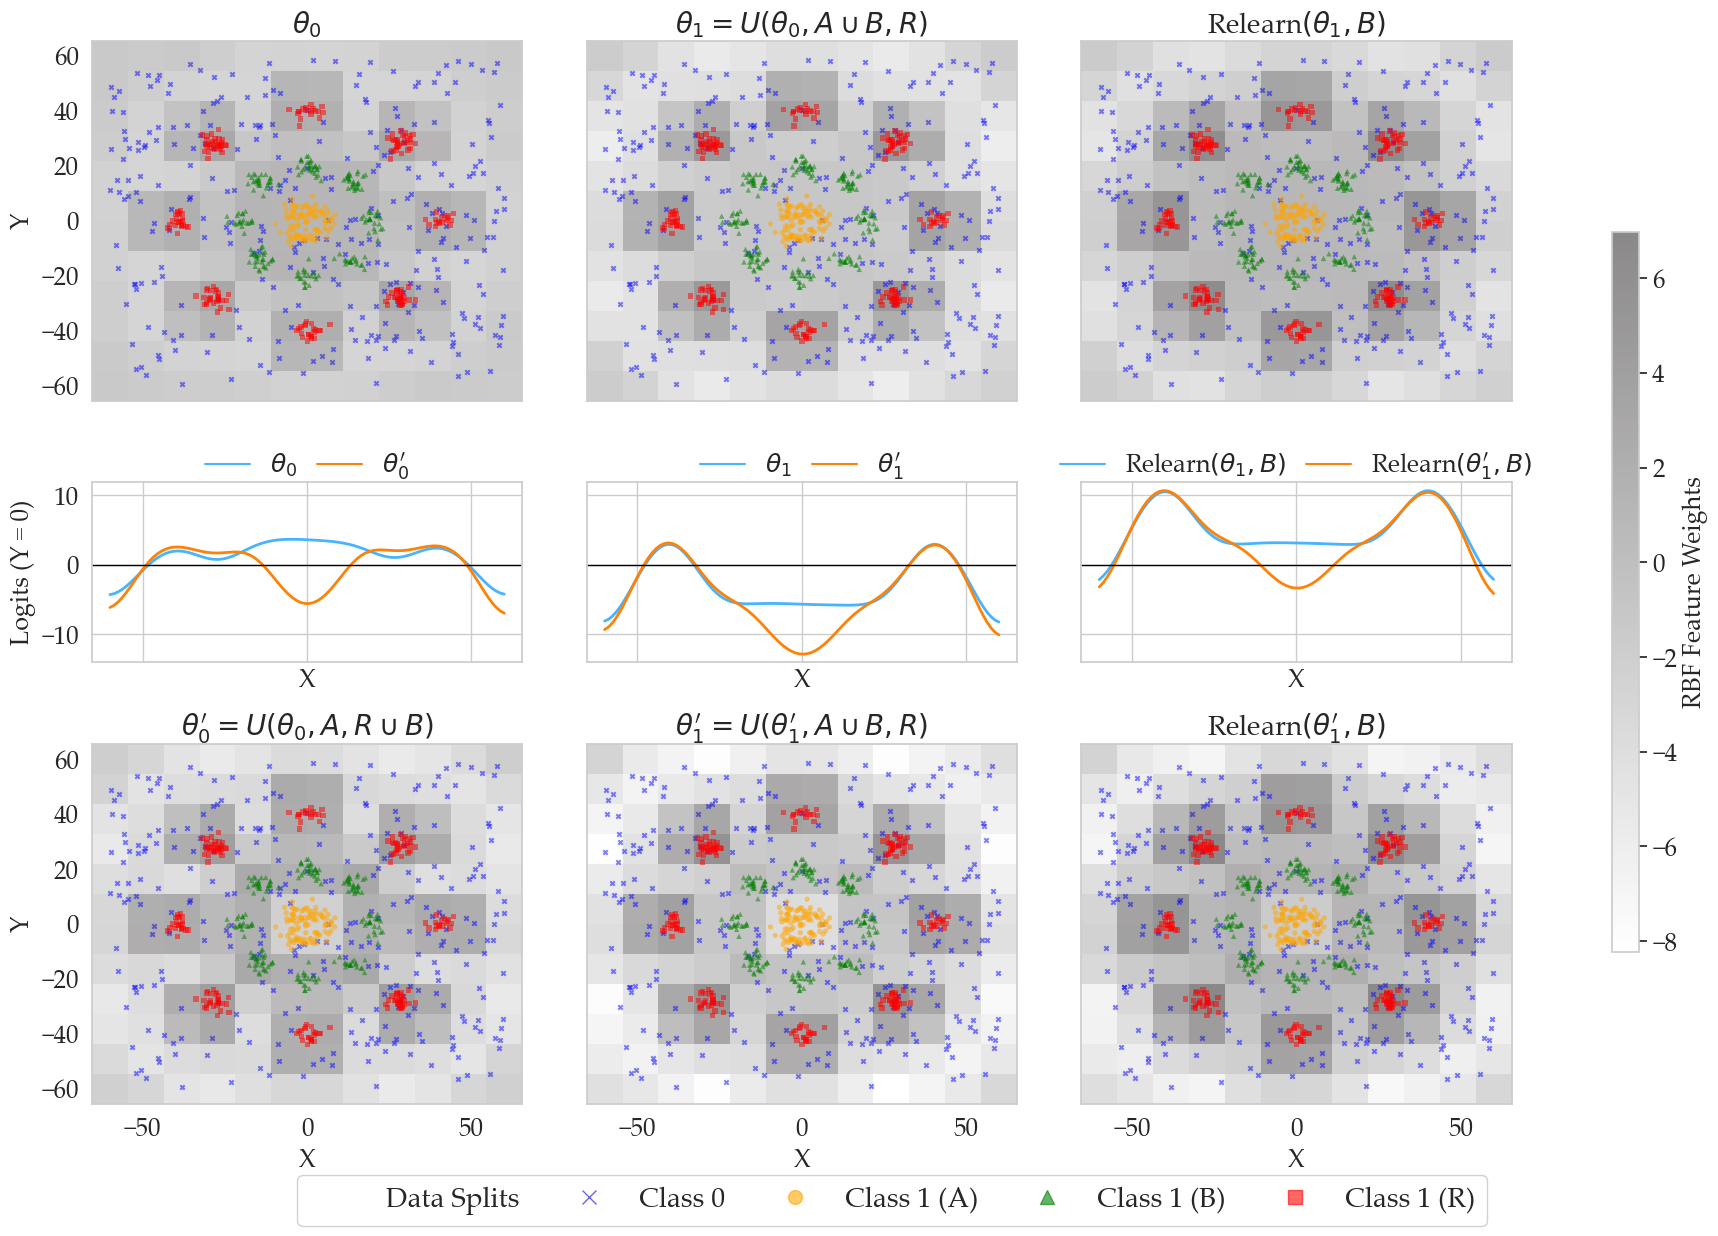

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

mpl.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif", "Times New Roman", "serif"]
plt.rcParams["text.usetex"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set_theme(
    style="whitegrid", rc={"font.family": "serif", "font.serif": ["Palatino Linotype"]}
)
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

mid_fontsize = 18
big_fontsize = 20

marker_map = {
    "Null": "x",
    "A": "o",
    "B": "^",
    "Retain": "s",
}
size_map = {
    "Null": 10,
    "A": 15,
    "B": 15,
    "Retain": 15,
}
point_limit = {
    "Null": 300,
    "A": 100,
    "B": 200,
    "Retain": 200,
}

alpha = 0.5


def plot_heatmaps_with_comparative_logits(
    datasets,
    z_values,
    model_names,
    labels,
    logits,
    X_full,
    cmap="coolwarm",
    annotate=False,
    continuous=False,
    n_points=1000,
    use_rings=False,
):
    import torch

    fig, axes = plt.subplots(
        3,
        3,
        figsize=(18, 12),
        squeeze=False,
        gridspec_kw={"height_ratios": [2, 1, 2]},
        sharex="col",
        sharey="row",
    )

    all_z = np.concatenate(z_values)
    vmin, vmax = all_z.min(), all_z.max()

    scatter_handles = []
    circle_handles = []
    scatter_points = {}

    for i in range(3):
        # ========== Row 0: Top Heatmaps ==========
        ax_top = axes[0, i]
        idx_top = i
        name_top = model_names[idx_top]
        label_top = labels[idx_top]
        data_top = datasets[idx_top]
        z_flat_top = z_values[idx_top]

        N = int(np.sqrt(data_top.shape[0]))
        xg = data_top[:, 0].reshape(N, N)
        yg = data_top[:, 1].reshape(N, N)
        zg = z_flat_top.reshape(N, N)

        if continuous:
            pcm = ax_top.imshow(
                zg,
                extent=[xg.min(), xg.max(), yg.min(), yg.max()],
                origin="lower",
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                aspect="auto",
                interpolation="bilinear",
            )
        else:
            pcm = ax_top.pcolormesh(
                xg, yg, zg, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax
            )

        ax_top.set_title(label_top, fontsize=big_fontsize)
        if use_rings:
            if name_top in ["base-lu", "base-lu-B"]:
                circle1 = plt.Circle(
                    (0, 0),
                    15,
                    color="black",
                    fill=False,
                    linestyle="dashed",
                    label="$I_A$",
                )
                ax_top.add_artist(circle1)
                circle_handles.append(circle1)
            if name_top in ["base", "base-lu"]:
                circle2 = plt.Circle(
                    (0, 0),
                    28,
                    color="black",
                    fill=False,
                    linestyle="solid",
                    label="$I_{AB}$",
                )
                ax_top.add_artist(circle2)
                circle_handles.append(circle2)

        # Scatter
        colors = ["blue", "orange", "green", "red"]
        labels_scatter = ["Null", "A", "B", "Retain"]
        for x_scat, color, label in zip(X_full, colors, labels_scatter):
            # Randomly sample points for scatter plot
            limit = n_points
            limit = min(limit, point_limit[label])
            if x_scat.shape[0] > limit:
                indices = torch.randperm(x_scat.shape[0])[:limit]
                x_scat = x_scat[indices]
            if scatter_points.get(label) is None:
                scatter_points[label] = x_scat
            x_scat = scatter_points[label]
            pts = ax_top.scatter(
                x_scat[:, 0].cpu(),
                x_scat[:, 1].cpu(),
                alpha=alpha,
                color=color,
                label=label,
                s=size_map[label],
                marker=marker_map[label],
                edgecolor="black" if label == "Null" else "none",
            )
            if i == 0:  # only add handle once
                scatter_handles.append(pts)

        ax_top.tick_params(axis="both", labelsize=mid_fontsize)
        if i == 0:
            ax_top.set_ylabel("Y", fontsize=mid_fontsize)

        # ========== Row 1: Comparative Logits ==========
        ax_mid = axes[1, i]
        x0, z0 = logits[idx_top]
        x1, z1 = logits[idx_top + 3]

        # Plot with colors
        ax_mid.plot(
            x0, z0, label=labels[idx_top], color="#48b3ff", linestyle="-", linewidth=2
        )
        ax_mid.plot(
            x1,
            z1,
            label=labels[idx_top + 3],
            color="#fd8207",
            linestyle="-",
            linewidth=2,
        )

        # Add dark zero line
        ax_mid.axhline(0, color="black", linestyle="-", linewidth=1)

        ax_mid.set_xlabel("X", fontsize=mid_fontsize)
        if i == 0:
            ax_mid.set_ylabel("Logits (Y = 0)", fontsize=mid_fontsize)
        ax_mid.tick_params(axis="both", labelsize=mid_fontsize)

        def format_mid_label(label):
            idx = label.rfind("=")
            if idx != -1:
                label = label[:idx]
                label += "$"
            return label.strip()

        ax_mid.legend(
            handles=[
                plt.Line2D(
                    [0],
                    [0],
                    color="#48b3ff",
                    linestyle="-",
                    label=format_mid_label(labels[idx_top]),
                ),
                plt.Line2D(
                    [0],
                    [0],
                    color="#fd8207",
                    linestyle="-",
                    label=format_mid_label(labels[idx_top + 3]),
                ),
            ],
            fontsize=mid_fontsize,
            loc="lower center",
            bbox_to_anchor=(0.5, 0.88),  # Adjust height above plot
            ncol=2,
            frameon=False,
            handlelength=1.8,
            columnspacing=0.8,  # Reduce space between items
        )
        ax_mid.set_title(None)  # ensures no space for title
        # ax_mid.legend(
        #     handles=[
        #         plt.Line2D([0], [0], color="#48b3ff", linestyle="-", label=format_mid_label(labels[idx_top])),
        #         plt.Line2D([0], [0], color="#fd8207", linestyle="-", label=format_mid_label(labels[idx_top + 3])),
        #     ],
        #     fontsize=mid_fontsize,
        #     loc="upper right",
        # )

        # ========== Row 2: Bottom Heatmaps ==========
        ax_bot = axes[2, i]
        idx_bot = idx_top + 3
        name_bot = model_names[idx_bot]
        label_bot = labels[idx_bot]
        data_bot = datasets[idx_bot]
        z_flat_bot = z_values[idx_bot]

        xg_bot = data_bot[:, 0].reshape(N, N)
        yg_bot = data_bot[:, 1].reshape(N, N)
        zg_bot = z_flat_bot.reshape(N, N)

        if continuous:
            pcm = ax_bot.imshow(
                zg_bot,
                extent=[xg_bot.min(), xg_bot.max(), yg_bot.min(), yg_bot.max()],
                origin="lower",
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                aspect="auto",
                interpolation="bilinear",
            )
        else:
            pcm = ax_bot.pcolormesh(
                xg_bot, yg_bot, zg_bot, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax
            )

        ax_bot.set_title(label_bot, fontsize=big_fontsize)
        if use_rings:
            if name_bot in ["base-lu", "base-lu-B"]:
                circle1 = plt.Circle(
                    (0, 0),
                    15,
                    color="black",
                    fill=False,
                    linestyle="dashed",
                    label="$I_A$",
                )
                ax_bot.add_artist(circle1)
            if name_bot in ["base", "base-lu"]:
                circle2 = plt.Circle(
                    (0, 0),
                    28,
                    color="black",
                    fill=False,
                    linestyle="solid",
                    label="$I_{{AB}}$",
                )
                ax_bot.add_artist(circle2)

        for x_scat, color, label in zip(X_full, colors, labels_scatter):
            # Randomly sample points for scatter plot
            limit = n_points
            limit = min(limit, point_limit[label])
            if x_scat.shape[0] > limit:
                indices = torch.randperm(x_scat.shape[0])[:limit]
                x_scat = x_scat[indices]
            if scatter_points.get(label) is None:
                scatter_points[label] = x_scat
            x_scat = scatter_points[label]
            ax_bot.scatter(
                x_scat[:, 0].cpu(),
                x_scat[:, 1].cpu(),
                alpha=alpha,
                color=color,
                s=size_map[label],
                marker=marker_map[label],
                edgecolor="black" if label == "Null" else "none",
            )

        if i == 0:
            ax_bot.set_ylabel("Y", fontsize=mid_fontsize)
        ax_bot.set_xlabel("X", fontsize=mid_fontsize)
        ax_bot.tick_params(axis="both", labelsize=mid_fontsize)

    # Global colorbar
    fig.subplots_adjust(right=0.88, hspace=0.4)
    cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
    fig.colorbar(pcm, cax=cbar_ax, label="RBF Feature Weights").ax.tick_params(
        labelsize=mid_fontsize
    )
    cbar_ax.yaxis.label.set_size(mid_fontsize)

    # Combined Legend
    all_handles = [
        plt.Line2D(
            [0],
            [0],
            marker=marker_map[label],
            color="w",
            markerfacecolor=handle.get_facecolor()[0] if label != "Null" else "none",
            markeredgecolor=handle.get_facecolor()[0],
            markersize=10,
            alpha=0.6,
            label=label,
        )
        for handle, label in zip(scatter_handles, ["Null", "A", "B", "Retain"])
    ]
    all_labels = ["Null", "A", "B", "Retain"]
    all_labels = ["Class 0", "Class 1 (A)", "Class 1 (B)", "Class 1 (R)"]
    if use_rings:
        all_handles = [
            plt.Line2D([0], [0], color="black", linestyle="dashed", label="$I_A$"),
            plt.Line2D([0], [0], color="black", linestyle="solid", label="$I_{{AB}}$"),
        ]
        all_labels += ["$I_A$", "$I_{{AB}}$"]

    # fig.legend(
    #     handles=all_handles,
    #     labels=all_labels,
    #     loc="lower right",
    #     bbox_to_anchor=(0.96, 0.01),
    #     fontsize=big_fontsize,
    #     title="Legend",
    #     title_fontsize=big_fontsize,
    #     frameon=True,
    #     framealpha=0.9,
    # )
    fig.legend(
        handles=[
            plt.Line2D(
                [0], [0], color="white", label="Data Scatters"
            ),  # fake handle for inline title
            *all_handles,
        ],
        labels=["Data Splits", *all_labels],  # inline label/title
        loc="lower center",
        bbox_to_anchor=(0.5, -0.04),  # Slightly lower to make room
        ncol=len(all_labels) + 1,  # +1 for the "Data Scatters" label
        fontsize=big_fontsize,
        frameon=True,
        framealpha=0.9,
        handlelength=2.0,
        columnspacing=1.5,
    )
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig(
        "heatmap_comparative_logits_with_scatter.svg", dpi=300, bbox_inches="tight"
    )
    plt.show()


model_names = ["init", "base", "base-B", "base-lu-partial", "base-lu", "base-lu-B"]
labels = [
    "$\\theta_0$",
    "$\\theta_1 = U(\\theta_0, A\\cup B, R)$",
    "Relearn$(\\theta_1, B)$",
    "$\\theta_0' = U(\\theta_0, A,  R \\cup B)$",
    "$\\theta_1' = U(\\theta_1', A\\cup B, R)$",
    "Relearn$(\\theta_1', B)$",
]
# labels = [
#     "Original",
#     "U",
#     "U (Relearn B)",
#     "LU (Partial)",
#     "LU",
#     "LU (Relearn B)",
# ]

# labels = [
#     "$\mathregular{\\theta_0}$",
#     "$\mathregular{\\theta_{AB}}$",
# ]

datasets = [model_checkpoints[name].rbf for name in model_names]
z_values = [
    model_checkpoints[name].layers[-1].weight.detach().reshape(-1).cpu().numpy()
    for name in model_names
]
biases = [
    model_checkpoints[name].layers[-1].bias.detach().reshape(-1).cpu().numpy().item()
    for name in model_names
]
logits = []
n_points = 100
for name in model_names:
    x = np.linspace(-60, 60, n_points)
    y = np.zeros(n_points)

    X = np.stack([x, y], axis=1)
    model = model_checkpoints[name]
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        z = model(X_tensor).squeeze().cpu().numpy()
        # convert to logits
        z = np.log(z / (1 - z) + 1e-8)

    logits.append((x, z))
import matplotlib.colors as mcolors

light_gray = mcolors.LinearSegmentedColormap.from_list(
    "light_gray", ["white", "#8a8888"]
)
plot_heatmaps_with_comparative_logits(
    datasets,
    z_values,
    model_names,
    labels,
    logits,
    X_full,  # List of 4 tensors: Null, A, B, Retain (each N x 2)
    cmap=light_gray,
    annotate=False,
    continuous=False,
    n_points=300,
)

In [7]:
# eval along [60, 60] for y-axis
ddlogits = []
n_points = 100
for name in model_names:
    x = np.linspace(-60, 60, n_points)
    y = np.zeros(n_points)

    X = np.stack([x, y], axis=1)
    z_values = []
    model = model_checkpoints[name]
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        z = model(X_tensor).squeeze().cpu().numpy()
        # convert to logits
        z = np.log(z / (1 - z) + 1e-8)
        z_values.append(z)

    z = z_values[0]
    logits.append((x, z))

In [8]:
# eval along [60, 60] for y-axis
n_points = 100
x = np.linspace(-60, 60, n_points)
y = np.zeros(n_points)

X = np.stack([x, y], axis=1)
z_values = []
name = "base"
model = model_checkpoints[name]
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    z = model(X_tensor).squeeze().cpu().numpy()
    # convert to logits
    z = np.log(z / (1 - z) + 1e-8)
    z_values.append(z)

# plot values
plt.figure(figsize=(5, 2))
plt.plot(x, z_values[0], label=name)
plt.axhline(y=0.5, color="black", linestyle="--", label="Decision Boundary")
plt.xlim(-60, 60)
plt.ylim(-15, 15)
# dashed line at 0.5

(-15.0, 15.0)